<a href="https://colab.research.google.com/github/yurigalindo/PyTorchSamples/blob/main/Colab%20Notebooks/Pseudo_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!wget https://github.com/git-lfs/git-lfs/releases/download/v2.7.1/git-lfs-linux-amd64-v2.7.1.tar.gz
!tar -xvzf git-lfs-linux-amd64-v2.7.1.tar.gz
!./install.sh
!git lfs install
!git clone https://github.com/yurigalindo/MeteorosIC.git
!unzip ./MeteorosIC/labeled_data.zip -d ./MeteorosIC
#!unzip ./MeteorosIC/unlabeled_data.zip -d ./MeteorosIC/unlabeled_data
!find . -type f -empty -delete

In [ ]:
from __future__ import print_function, division 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
from skimage import io, transform
from PIL import ImageFile
from PIL import Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomOrder([
          transforms.Resize((400,400)),  
          transforms.RandomHorizontalFlip(),
          transforms.RandomRotation(45),
          transforms.RandomVerticalFlip()
          ]
        ),
        transforms.ColorJitter(0.5,0.5,0.5,0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((400,400)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
}

data_dir = './MeteorosIC'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
                            #,'unlabeled_data']}
'''
transforms.RandomResizedCrop((224,224),scale=(0.8, 1.0)),
    ,
    'unlabeled_data': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
'''

"\ntransforms.RandomResizedCrop((224,224),scale=(0.8, 1.0)),\n    ,\n    'unlabeled_data': transforms.Compose([\n        transforms.Resize((224,224)),\n        transforms.RandomHorizontalFlip(),\n        transforms.ToTensor(),\n        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])\n    ])\n"

In [ ]:
import matplotlib.pyplot as plt
import torch

class Learner:
    #adapt code for emulating big batches
    def __init__(self,model,criterion):
        self.model=model
        self.criterion=criterion
        self.device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def set_datasets(self,training,valid):
        self.training_dataset=training
        self.validation_dataset=valid
    def set_optimizer(self,optimizer,scheduler):
        self.optimizer=optimizer
        self.scheduler=scheduler
    def propagate_batch(self,inputs,labels):
        with torch.set_grad_enabled(True):
            outputs=self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
        with torch.no_grad():
            _,preds = torch.max(outputs, 1)
            corrects = torch.sum(preds==labels.data).item()
            size=inputs.size(0)
            loss_item=loss.item()
        del preds
        del outputs
        del loss
        del inputs
        del labels
        return loss_item*size,corrects
    def train_batch(self, inputs, labels):
        self.optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            outputs=self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
        with torch.no_grad():
            _,preds = torch.max(outputs, 1)
            corrects = torch.sum(preds==labels.data).item()
            size=inputs.size(0)
            loss_item=loss.item()
        del preds
        del outputs
        del loss
        del inputs
        del labels
        return loss_item*size,corrects

    def eval_batch(self, inputs, labels):
        with torch.no_grad():
            outputs=self.model(inputs)
            loss = self.criterion(outputs, labels)
            _,preds = torch.max(outputs, 1)
            corrects = torch.sum(preds==labels.data).item()
            size=inputs.size(0)
            loss_item=loss.item()
        del outputs
        del loss
        del preds
        del inputs
        del labels
        return loss_item*size,corrects

    def print_statistics(self,loss,accuracy):
        print("Avg Loss={}\nAccuracy={}".format(loss,accuracy))
    def ceildiv(self,a, b):
        """Return the celing of the division of a by b
        """
        return -(-a // b)
    def min_value(self,a,b):
        """Return the smaller of two values
        """
        if a>b:
            return b
        else:
            return a
    def max_value(self,a,b):
        """"Return the greater of two values
        """
        if b>a:
          return b
        else:
          return a

    def train(self,num_epochs,training_batchsize,validation_batchsize,batch_cap=32):
        """Train the learner's model for num_epochs on training batchsize, printing the train and validation loss and accuracy
        """
        train_dataloader=torch.utils.data.DataLoader(self.training_dataset,batch_size=training_batchsize,shuffle=True)
        valid_dataloader=torch.utils.data.DataLoader(self.validation_dataset,batch_size=validation_batchsize,shuffle=True)
        training_batches=self.ceildiv(len(self.training_dataset),training_batchsize)
        micro_batches=training_batchsize//batch_cap #accuracy statistics will only work properly if training batch is divisible by batch_cap
        validation_batches=self.ceildiv(len(self.validation_dataset),validation_batchsize)
        since = time.time()
        train_losses=[]
        valid_losses=[]
        print(micro_batches)
        print(micro_batches*batch_cap)
        print(training_batches)
        print(len(training_dataset))
        for epoch in range(num_epochs):
            print("Epoch {} of {}".format(epoch,num_epochs-1))
            self.scheduler.step()
            

            self.model.train()
            #Train model
            loss = 0
            corrects = 0
            iterator = iter(train_dataloader)
            #for batch in range(training_batches):
            for batch in range(training_batches):
                self.optimizer.zero_grad()
                for micro_batch in range(micro_batches):
                  inputs,labels=next(iterator)
                  new_loss , new_corrects = self.propagate_batch(inputs.to(self.device),labels.to(self.device))
                  loss+=new_loss
                  corrects+=new_corrects
                  del inputs
                  del labels
                  torch.cuda.empty_cache()
                self.optimizer.step()
                del new_loss
                del new_corrects
                torch.cuda.empty_cache()
            
            train_losses.append(loss)
            print("Training:")
            self.print_statistics(loss/len(self.training_dataset),corrects/len(self.training_dataset))
            
            
            self.model.eval()
            #Evaluate model
            loss = 0
            corrects = 0
            iterator = iter(valid_dataloader)
            for batch in range(validation_batches):
                inputs,labels=next(iterator)
                new_loss , new_corrects=self.eval_batch(inputs.to(self.device),labels.to(self.device))
                loss+=new_loss
                corrects+=new_corrects
                del inputs
                del labels
                del new_loss
                del new_corrects
                torch.cuda.empty_cache()
            valid_losses.append(loss)
            print("Validation:")
            self.print_statistics(loss/len(self.validation_dataset),corrects/len(self.validation_dataset))
            print()

        time_elapsed = time.time() - since
        print("Total time:{}".format(time_elapsed))
        plt.plot(range(num_epochs),train_losses,'r',range(num_epochs),valid_losses,'b')
        del train_dataloader
        del valid_dataloader
        del train_losses
        del valid_losses
        torch.cuda.empty_cache()
    def predict(self,dataset,batchsize,num_classes):
        """Return a tensor containing the probability of each class
        """
        dataloader=torch.utils.data.DataLoader(dataset,batch_size=batchsize,shuffle=False)
        dataset_len=len(dataset)
        num_batches=self.ceildiv(dataset_len,batchsize)
        since = time.time()
        predictions = torch.zeros((len(dataset),num_classes)).to(self.device)
        self.model.eval()
        iterator = iter(dataloader)
        with torch.no_grad():
          for batch in range(num_batches):
              inputs, _ = next(iterator)
              inputs = inputs.to(self.device)
              logits =  self.model(inputs)
              del inputs
              unnormalized_probabilities = torch.exp(logits)
              del logits
              denominators = torch.sum(unnormalized_probabilities,1,True)
              probabilities= torch.div(unnormalized_probabilities,denominators)
              del denominators
              del unnormalized_probabilities
              indexes=torch.tensor(range(batch*batchsize,self.min_value((batch+1)*batchsize,dataset_len))).to(self.device)
              predictions.index_copy_(0,indexes,probabilities)
              del indexes
              del probabilities
              torch.cuda.empty_cache()
          predictions_cpu=predictions.cpu()
        del predictions
        del dataloader
        torch.cuda.empty_cache()
        return predictions_cpu

In [ ]:
import torch
class PseudoLearner(Learner):
0.0045  """"Specialization of the Learner class that has an unlabeled dataset and can apply pseudo labeling
  """
  def set_datasets(self,training,valid,unlabeled):
    Learner.set_datasets(self,training,valid)
    self.unlabeled_dataset=unlabeled
  def filter(self,outputs):
    confidence=0.10
    probs = torch.exp(outputs[:,0])/ (torch.exp(outputs[:,1])+torch.exp(outputs[:,0])) #applying softmax
    a=probs<confidence
    b=probs>1-confidence
    del probs
    a=a+b #applying XOR
    return a
  def pseudo_propagate(self,inputs):
    with torch.set_grad_enabled(True):
      outputs=self.model(inputs)
      filt = self.filter(outputs)
      outputs=outputs[torch.cuda.ByteTensor(filt)]
      if(len(outputs)!=0):
        with torch.no_grad():
          _,preds = torch.max(outputs, 1)
          size=inputs.size(0)
        loss = self.criterion(outputs, preds)
        loss=loss*self.alpha/len(outputs)
        loss.backward()
        loss_item=loss.item()
        del preds
        del outputs
        del loss
        del inputs
        return loss_item*size
      else:
        del outputs
        del inputs
        return 0
  
  def pseudo_train(self,num_epochs,training_batchsize,validation_batchsize,batch_cap=64,alpha=3,T2=5):
        """Train the learner's model for num_epochs on training batchsize, printing the train and validation loss and accuracy
        """
        train_dataloader=torch.utils.data.DataLoader(self.training_dataset,batch_size=training_batchsize,shuffle=True)
        valid_dataloader=torch.utils.data.DataLoader(self.validation_dataset,batch_size=validation_batchsize,shuffle=True)
        training_batches=self.ceildiv(len(self.training_dataset),training_batchsize)
        validation_batches=self.ceildiv(len(self.validation_dataset),validation_batchsize)
        pseudo_batchsize=self.ceildiv(len(self.unlabeled_dataset),training_batches)
        self.num_micro_batches=pseudo_batchsize//batch_cap
        unlabeled_dataloader=torch.utils.data.DataLoader(self.unlabeled_dataset,
                                                         batch_size=batch_cap,
                                                         shuffle=True)
        since = time.time()
        train_losses=[]
        valid_losses=[]
        for epoch in range(num_epochs):
            if(epoch<T2):
              self.alpha=alpha*epoch/T2
            else:
              self.alpha=alpha
            print("Epoch {} of {}".format(epoch,num_epochs-1))
            self.scheduler.step()
            

            self.model.train()
            #Train model
            loss = 0
            pseudo_loss=0
            corrects = 0
            train_iterator = iter(train_dataloader)
            unlabeled_iterator = iter(unlabeled_dataloader)
            #for batch in range(training_batches):
            for batch in range(training_batches):
                inputs,labels=next(train_iterator)
                new_loss , new_corrects = self.train_batch(inputs.to(self.device),labels.to(self.device))
                loss+=new_loss
                corrects+=new_corrects
                del inputs
                del labels
                del new_loss
                del new_corrects
                self.optimizer.zero_grad()
                for micro_batch in range(self.num_micro_batches):
                  inputs,labels=next(unlabeled_iterator)
                  new_loss = self.pseudo_propagate(inputs.to(self.device))
                  pseudo_loss+=new_loss
                self.optimizer.step()
                del inputs
                del labels
                del new_loss
            
            train_losses.append(loss)
            print("Training:")
            self.print_statistics(loss,corrects/len(self.training_dataset))
            print("Pseudo Loss: {0}".format(pseudo_loss))
            
            self.model.eval()
            #Evaluate model
            loss = 0
            corrects = 0
            iterator = iter(valid_dataloader)
            for batch in range(validation_batches):
                inputs,labels=next(iterator)
                new_loss , new_corrects=self.eval_batch(inputs.to(self.device),labels.to(self.device))
                loss+=new_loss
                corrects+=new_corrects
                del inputs
                del labels
                del new_loss
                del new_corrects
            valid_losses.append(loss)
            print("Validation:")
            self.print_statistics(loss,corrects/len(self.validation_dataset))
            print()

        time_elapsed = time.time() - since
        print("Total time:{}".format(time_elapsed))
        plt.plot(range(num_epochs),train_losses,'r',range(num_epochs),valid_losses,'b')
        del train_dataloader
        del valid_dataloader
        del train_losses
        del valid_losses
        torch.cuda.empty_cache()
        return corrects/len(self.validation_dataset)

In [ ]:
def experiment(alfa,t2,pseudo_epochs,t1,learning_rate=1e-4,exponential_decay=0.94):
  %%capture
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
  model_ft = models.resnet50(pretrained=True)
  num_ftrs = model_ft.fc.in_features
  model_ft.fc = nn.Sequential(nn.Dropout(0.5),
                              nn.Linear(num_ftrs, 1024),
                              nn.ReLU(),
                              nn.Dropout(0.5),
                              nn.Linear(1024, 2)
                             )

  model_ft = model_ft.to(device)

  criterion = nn.CrossEntropyLoss()
  
  learner = PseudoLearner(model_ft,criterion)

  learner.set_datasets(image_datasets['train'],image_datasets['valid'],image_datasets['unlabeled_data'])
  optimizer = optim.Adam(model_ft.parameters(), lr = learning_rate)
  scheduler = optim.lr_scheduler.ExponentialLR(optimizer,exponential_decay)
  learner.set_optimizer(optimizer,scheduler)
  learner.train(t1,32,128)
  return 1-learner.pseudo_train(pseudo_epochs,32,128,alpha=alfa,T2=t2)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class UnflattenTo4d(nn.Module):
    def __init__(self):
        super(UnflattenTo4d, self).__init__()

    def forward(self, x):
       return x.view(-1, 2048, 1, 1)

class FlattenTo1d(nn.Module):
    def __init__(self):
        super(FlattenTo1d, self).__init__()

    def forward(self, x):
       return x.view(-1,2)


In [ ]:
from torchsummary import summary
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
model_ft = models.resnet50(pretrained=True)
#model_ft.aux_logits=False
num_ftrs = model_ft.fc.in_features

#for param in model_ft.parameters():
#    param.requires_grad = False

model_ft.fc=nn.Sequential(UnflattenTo4d(),
                          nn.Dropout(0.5),
                          nn.Conv2d(2048,2,1),
                          nn.AdaptiveAvgPool2d(1),
                          FlattenTo1d()
                          )

"""
model_ft.fc = nn.Sequential(nn.Dropout(0.5),
                            nn.Linear(num_ftrs, 1024),
                            nn.ReLU(),
                            nn.Dropout(0.5),
                            nn.Linear(1024, 2)
                           )
"""
model_ft = model_ft.to(device)
#summary(model_ft, (3,299,299))
'''model_ft.fc = nn.Sequential(
                            
                            nn.Dropout(0.6),
                            nn.Linear(num_ftrs, 2)
                           )'''
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 133786155.71it/s]


In [ ]:
ct = 0
for child in model_ft.children():
  ct += 1
  if ct < 6:
    for param in child.parameters():
        param.requires_grad = False
        param.requires_grad=True
  else:
    break
      

In [ ]:
!nvidia-smi

Mon May 20 20:22:53 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    27W /  70W |    887MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:

learner = Learner(model_ft,criterion)


optimizer = optim.Adam(model_ft.parameters(), lr = 1e-4)
optimizer= optim.SGD(model_ft.parameters(),lr=0.0045)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer,0.984)
learner.set_optimizer(optimizer,scheduler)

learner.set_datasets(image_datasets['train'],image_datasets['valid'])

learner.train(10,32,128,batch_cap=16)

learner.train(10,64,128,batch_cap=8)

learner.train(10,128,128,batch_cap=4)

2
32
120


NameError: ignored

start
Epoch 0 of 9
Training:
Total Loss=502.701200247
Accuracy=0.958814270724
Validation:
Total Loss=72.0726819038
Accuracy=0.9453125

Epoch 1 of 9
Training:
Total Loss=527.926697016
Accuracy=0.951731374607
Validation:
Total Loss=86.4028768539
Accuracy=0.943359375

Epoch 2 of 9
Training:
Total Loss=457.822256267
Accuracy=0.959601259182
Validation:
Total Loss=77.2530317307
Accuracy=0.9453125

Epoch 3 of 9
Training:
Total Loss=467.744298756
Accuracy=0.95907660021
Validation:
Total Loss=76.3339576721
Accuracy=0.94921875

Epoch 4 of 9
Training:
Total Loss=445.165982664
Accuracy=0.959601259182
Validation:
Total Loss=80.6891593933
Accuracy=0.947265625

Epoch 5 of 9
Training:
Total Loss=450.642774045
Accuracy=0.95907660021
Validation:
Total Loss=75.9087238312
Accuracy=0.953125

Epoch 6 of 9
Training:
Total Loss=450.768831313
Accuracy=0.960912906611
Validation:
Total Loss=75.8461093903
Accuracy=0.94921875

Epoch 7 of 9
Training:
Total Loss=434.470479071
Accuracy=0.960125918153
Validation:
Tota

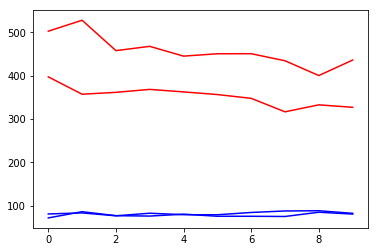

In [ ]:
learner.train(10,32,128)
learner.train(10,64,128)

start
Epoch 0 of 5
Training:
Total Loss=546.510215878
Accuracy=0.868698710434
Validation:
Total Loss=86.7257877737
Accuracy=0.924939467312

Epoch 1 of 5
Training:
Total Loss=309.51176931
Accuracy=0.936107854631
Validation:
Total Loss=137.61622265
Accuracy=0.874092009685

Epoch 2 of 5
Training:
Total Loss=194.935015693
Accuracy=0.958968347011
Validation:
Total Loss=93.1940025687
Accuracy=0.929782082324

Epoch 3 of 5
Training:
Total Loss=161.444325238
Accuracy=0.969519343494
Validation:
Total Loss=103.831637658
Accuracy=0.922518159806

Epoch 4 of 5
Training:
Total Loss=123.316209182
Accuracy=0.974794841735
Validation:
Total Loss=76.64948944
Accuracy=0.937046004843

Epoch 5 of 5
Training:
Total Loss=132.650137663
Accuracy=0.975967174678
Validation:
Total Loss=100.936028376
Accuracy=0.917675544794

Total time:236.802860022


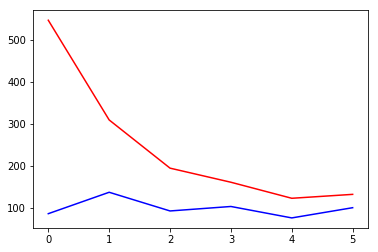

In [ ]:

learner = PseudoLearner(model_ft,criterion)

learner.set_datasets(image_datasets['train'],image_datasets['valid'],image_datasets['unlabeled_data'])
optimizer = optim.Adam(model_ft.parameters(), lr = 1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer,0.94)
learner.set_optimizer(optimizer,scheduler)
learner.train(6,32,128)

Epoch 0 of 4
Training:
Total Loss=184.027997106
Accuracy=0.970105509965
Pseudo Loss: 6.22733431682
Validation:
Total Loss=118.134937644
Accuracy=0.910411622276

Epoch 1 of 4
Training:
Total Loss=138.382054985
Accuracy=0.978311840563
Pseudo Loss: 6.08687981591
Validation:
Total Loss=89.9237380177
Accuracy=0.946731234867

Epoch 2 of 4
Training:
Total Loss=133.357426999
Accuracy=0.973036342321
Pseudo Loss: 5.35906193452
Validation:
Total Loss=130.835965306
Accuracy=0.915254237288

Epoch 3 of 4
Training:
Total Loss=137.85690926
Accuracy=0.974794841735
Pseudo Loss: 5.58558519743
Validation:
Total Loss=133.898782521
Accuracy=0.927360774818

Epoch 4 of 4
Training:
Total Loss=120.0862602
Accuracy=0.978311840563
Pseudo Loss: 4.1904131053
Validation:
Total Loss=122.552848041
Accuracy=0.917675544794

Total time:1443.44488406


0.9176755447941889

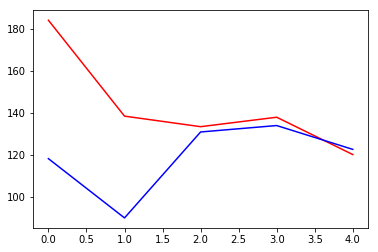

In [ ]:

learner = PseudoLearner(model_ft,criterion)

learner.set_datasets(image_datasets['train'],image_datasets['valid'],image_datasets['unlabeled_data'])
optimizer = optim.Adam(model_ft.parameters(), lr = 1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer,0.94)
learner.set_optimizer(optimizer,scheduler)

learner.pseudo_train(5,32,128,T2=-1,alpha=3)

start
Epoch 0 of 1
Training:
Total Loss=541.246224642
Accuracy=0.875146541618
Validation:
Total Loss=109.900248408
Accuracy=0.886198547215

Epoch 1 of 1
Training:
Total Loss=313.477355525
Accuracy=0.927901524033
Validation:
Total Loss=83.6361559629
Accuracy=0.929782082324

Total time:139.080847025
Mon Apr 22 17:42:37 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    45W /  70W |   5767MiB / 15079MiB |     23%      Default |
+----------------------------

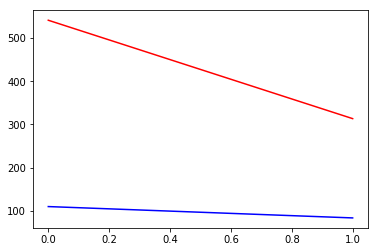

In [ ]:
#for param in model_ft.parameters():
#    param.requires_grad = True
learner = Learner(model_ft,criterion)

learner.set_datasets(image_datasets['train'],image_datasets['valid'])
optimizer = optim.Adam(model_ft.parameters(), lr = 1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer,0.94)
learner.set_optimizer(optimizer,scheduler)
learner.train(2,32,128)
!nvidia-smi 

In [ ]:
import torch
import gc
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size())
    except: pass

In [ ]:
def pretty_size(size):
	"""Pretty prints a torch.Size object"""
	assert(isinstance(size, torch.Size))
	return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
	"""Prints a list of the Tensors being tracked by the garbage collector."""
	import gc
	total_size = 0
	for obj in gc.get_objects():
		try:
			if torch.is_tensor(obj):
				if not gpu_only or obj.is_cuda:
					print("%s:%s%s %s" % (type(obj).__name__, 
										  " GPU" if obj.is_cuda else "",
										  " pinned" if obj.is_pinned else "",
										  pretty_size(obj.size())))
					total_size += obj.numel()
			elif hasattr(obj, "data") and torch.is_tensor(obj.data):
				if not gpu_only or obj.is_cuda:
					print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
												   type(obj.data).__name__, 
												   " GPU" if obj.is_cuda else "",
												   " pinned" if obj.data.is_pinned else "",
												   " grad" if obj.requires_grad else "", 
												   " volatile" if obj.volatile else "",
												   pretty_size(obj.data.size())))
					total_size += obj.data.numel()
		except Exception as e:
			pass        
	print("Total size:", total_size)

In [ ]:
learner = Learner(model_ft,criterion)
predictions = learner.predict(image_datasets['valid'],32,2)

In [ ]:
torch.cuda.memory_allocated(device=device)

973602304L

In [ ]:
predictions = learner.predict(image_datasets['valid'],32,2)
print (predictions)

tensor([[9.7107e-01, 2.8930e-02],
        [9.9409e-01, 5.9138e-03],
        [9.9434e-01, 5.6583e-03],
        [9.2694e-01, 7.3063e-02],
        [9.4749e-01, 5.2513e-02],
        [9.7170e-01, 2.8296e-02],
        [9.0024e-01, 9.9764e-02],
        [9.9615e-01, 3.8476e-03],
        [9.9005e-01, 9.9537e-03],
        [9.2296e-01, 7.7040e-02],
        [9.8799e-01, 1.2014e-02],
        [9.4046e-01, 5.9544e-02],
        [9.5452e-01, 4.5484e-02],
        [9.9867e-01, 1.3272e-03],
        [9.8026e-01, 1.9741e-02],
        [9.3391e-01, 6.6091e-02],
        [9.8014e-01, 1.9857e-02],
        [9.6157e-01, 3.8430e-02],
        [9.9371e-01, 6.2917e-03],
        [9.7246e-01, 2.7539e-02],
        [9.9820e-01, 1.7979e-03],
        [9.9596e-01, 4.0431e-03],
        [9.9376e-01, 6.2400e-03],
        [9.9642e-01, 3.5805e-03],
        [9.9194e-01, 8.0646e-03],
        [8.5583e-01, 1.4417e-01],
        [9.8920e-01, 1.0797e-02],
        [9.0321e-01, 9.6790e-02],
        [9.9534e-01, 4.6636e-03],
        [9.716

In [ ]:
labels = [image_datasets['valid'][i][1] for i in range(len(image_datasets['valid']))]

In [ ]:
print(len(labels))

413


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(40,20))
"""Analysis done for two class case
"""
def most_label(predictions,class_label,quantity):
  """Return the indexes of predictions of highes probabilty for that class label
  """
  predictions=torch.index_select(predictions,1,torch.tensor(class_label)) #Select columns of that label
  indexes = torch.argsort(predictions,0,True)
  indexes = torch.flatten(indexes)
  return indexes[:quantity]

def most_correct(predictions,true_labels,quantity):
  """Return the indexes of predictions that are closest to the true label
  """
  true_labels = torch.tensor(true_labels,dtype=torch.float32)
  difference= torch.abs(torch.add(predictions[:,1],torch.neg(true_labels)))
  indexes = torch.argsort(difference,0,False)
  indexes = torch.flatten(indexes)
  return indexes[:quantity]

def most_wrong(predictions,true_labels,quantity):
  """Return the indexes of predictions that are furthest from the true label
  """
  true_labels = torch.tensor(true_labels,dtype=torch.float32)
  difference= torch.abs(torch.add(predictions[:,1],torch.neg(true_labels)))
  indexes = torch.argsort(difference,0,True)
  indexes = torch.flatten(indexes)
  return indexes[:quantity]
def filter_correct(predictions,dataset,correct=True):
  """"Return filtered predictions that are correct or wrong, according to the correct param
  """
  #PROBLEM:RETURNS PREDICTIONS WITHOUT INDEXES
  #To get indexes: indexes = torch.tensor(range(len(dataset)))
  #indexes = indexes[predicted_labels==labels]
  labels = [dataset[i][1] for i in range(len(dataset))]
  labels = torch.tensor(labels)
  predicted_labels=torch.argmax(predictions, dim=1)
  if(correct):
    print(predictions[predicted_labels==labels])
    return predictions[predicted_labels==labels]
  else:
    print(predictions[predicted_labels!=labels])
    return predictions[predicted_labels!=labels]
  
def show_images(indexes,dataset,title=None):  
  """"Use pyplot to show the images of the dataset at indexes
  """
  images = torch.stack([dataset[i][0] for i in indexes.tolist()]) #Stack the images of dataset indexes
  labels = [dataset[i][1] for i in indexes.tolist()]
  plt.ion()
  images = torchvision.utils.make_grid(images)
  inp = images.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)  # pause a bit so that plots are updated
  print(labels)

#predictions=filter_correct(predictions,image_datasets['valid'],correct=False)
#indexes = most_label(predictions,1,50)
#show_images(indexes,image_datasets['valid'])

<Figure size 2880x1440 with 0 Axes>

In [ ]:
print(predictions[most_wrong(predictions,labels,50),1])

tensor([0.0026, 0.0029, 0.0138, 0.0175, 0.0204, 0.0297, 0.0563, 0.0577, 0.0638,
        0.0641, 0.0711, 0.1240, 0.1285, 0.1335, 0.1891, 0.2108, 0.2203, 0.3110,
        0.3137, 0.3382, 0.3612, 0.3679, 0.3952, 0.4028, 0.4255, 0.4519, 0.5002,
        0.5420, 0.5743, 0.5861, 0.5970, 0.6004, 0.6004, 0.6589, 0.6751, 0.7329,
        0.2359, 0.7657, 0.7747, 0.7764, 0.8111, 0.8208, 0.8381, 0.1501, 0.8502,
        0.8507, 0.1442, 0.1217, 0.1186, 0.0998])


In [ ]:
print(torch.tensor(labels)[most_wrong(predictions,labels,50)])

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0.])


In [ ]:
print(torch.tensor(labels,dtype=torch.float32)[most_wrong(predictions,labels,50)]-predictions[most_wrong(predictions,labels,50),1])

tensor([ 0.9974,  0.9971,  0.9862,  0.9825,  0.9796,  0.9703,  0.9437,  0.9423,
         0.9362,  0.9359,  0.9289,  0.8760,  0.8715,  0.8665,  0.8109,  0.7892,
         0.7797,  0.6890,  0.6863,  0.6618,  0.6388,  0.6321,  0.6048,  0.5972,
         0.5745,  0.5481,  0.4998,  0.4580,  0.4257,  0.4139,  0.4030,  0.3996,
         0.3996,  0.3411,  0.3249,  0.2671, -0.2359,  0.2343,  0.2253,  0.2236,
         0.1889,  0.1792,  0.1619, -0.1501,  0.1498,  0.1493, -0.1442, -0.1217,
        -0.1186, -0.0998])


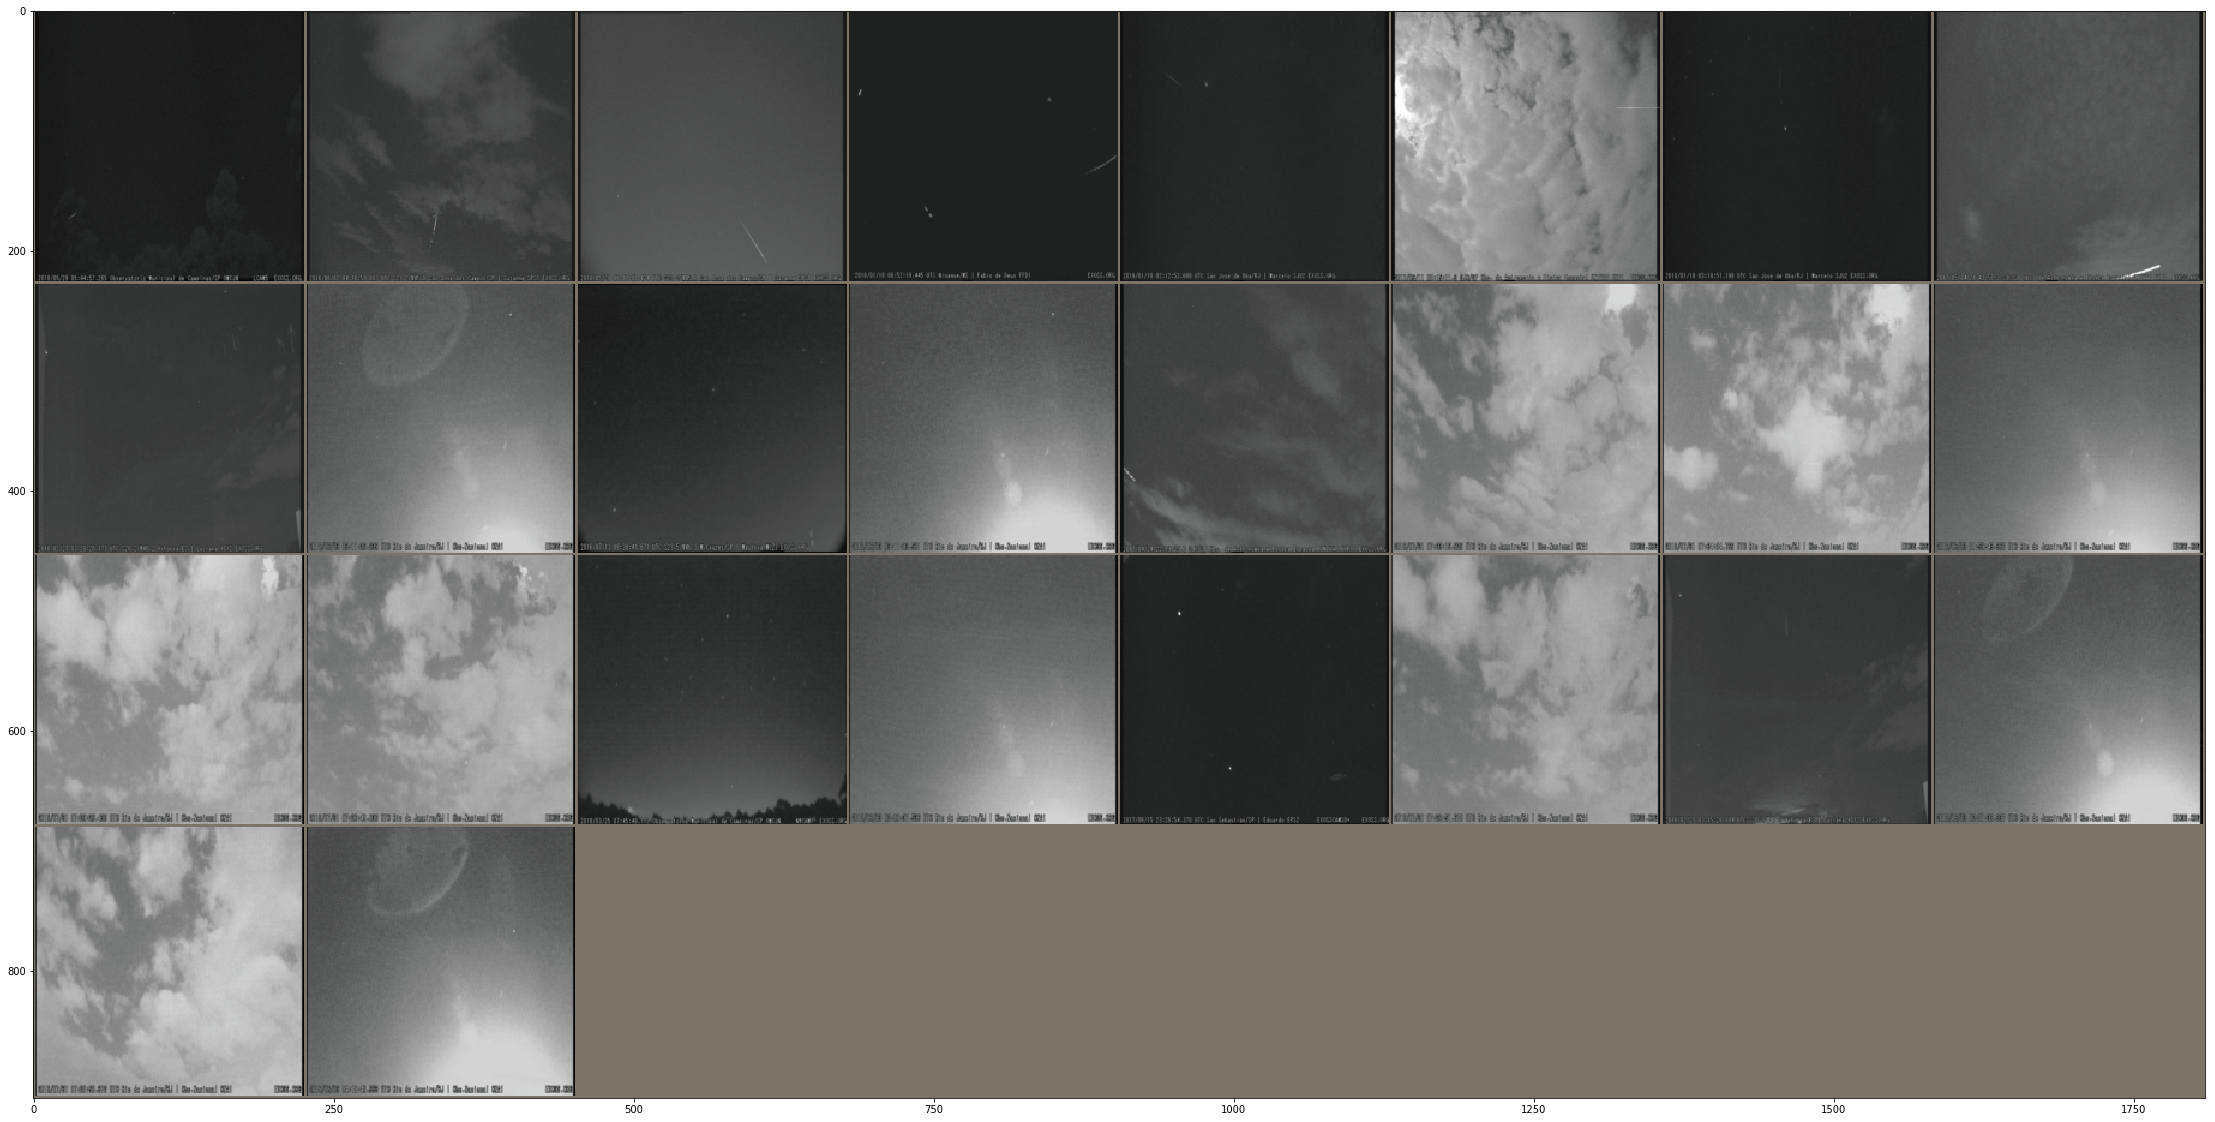

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
plt.figure(figsize=(40,20))
show_images(most_wrong(predictions,labels,26),image_datasets['valid'])

In [ ]:
print(most_label(filtered_predictions,0,36))

tensor([33, 31, 32, 13, 21, 35, 11, 15, 19, 20, 10, 25, 18, 12, 26, 17, 22, 30,
        23, 34, 16, 28, 24, 27, 29, 14,  0,  6,  9,  3,  1,  2,  4,  8,  7,  5])


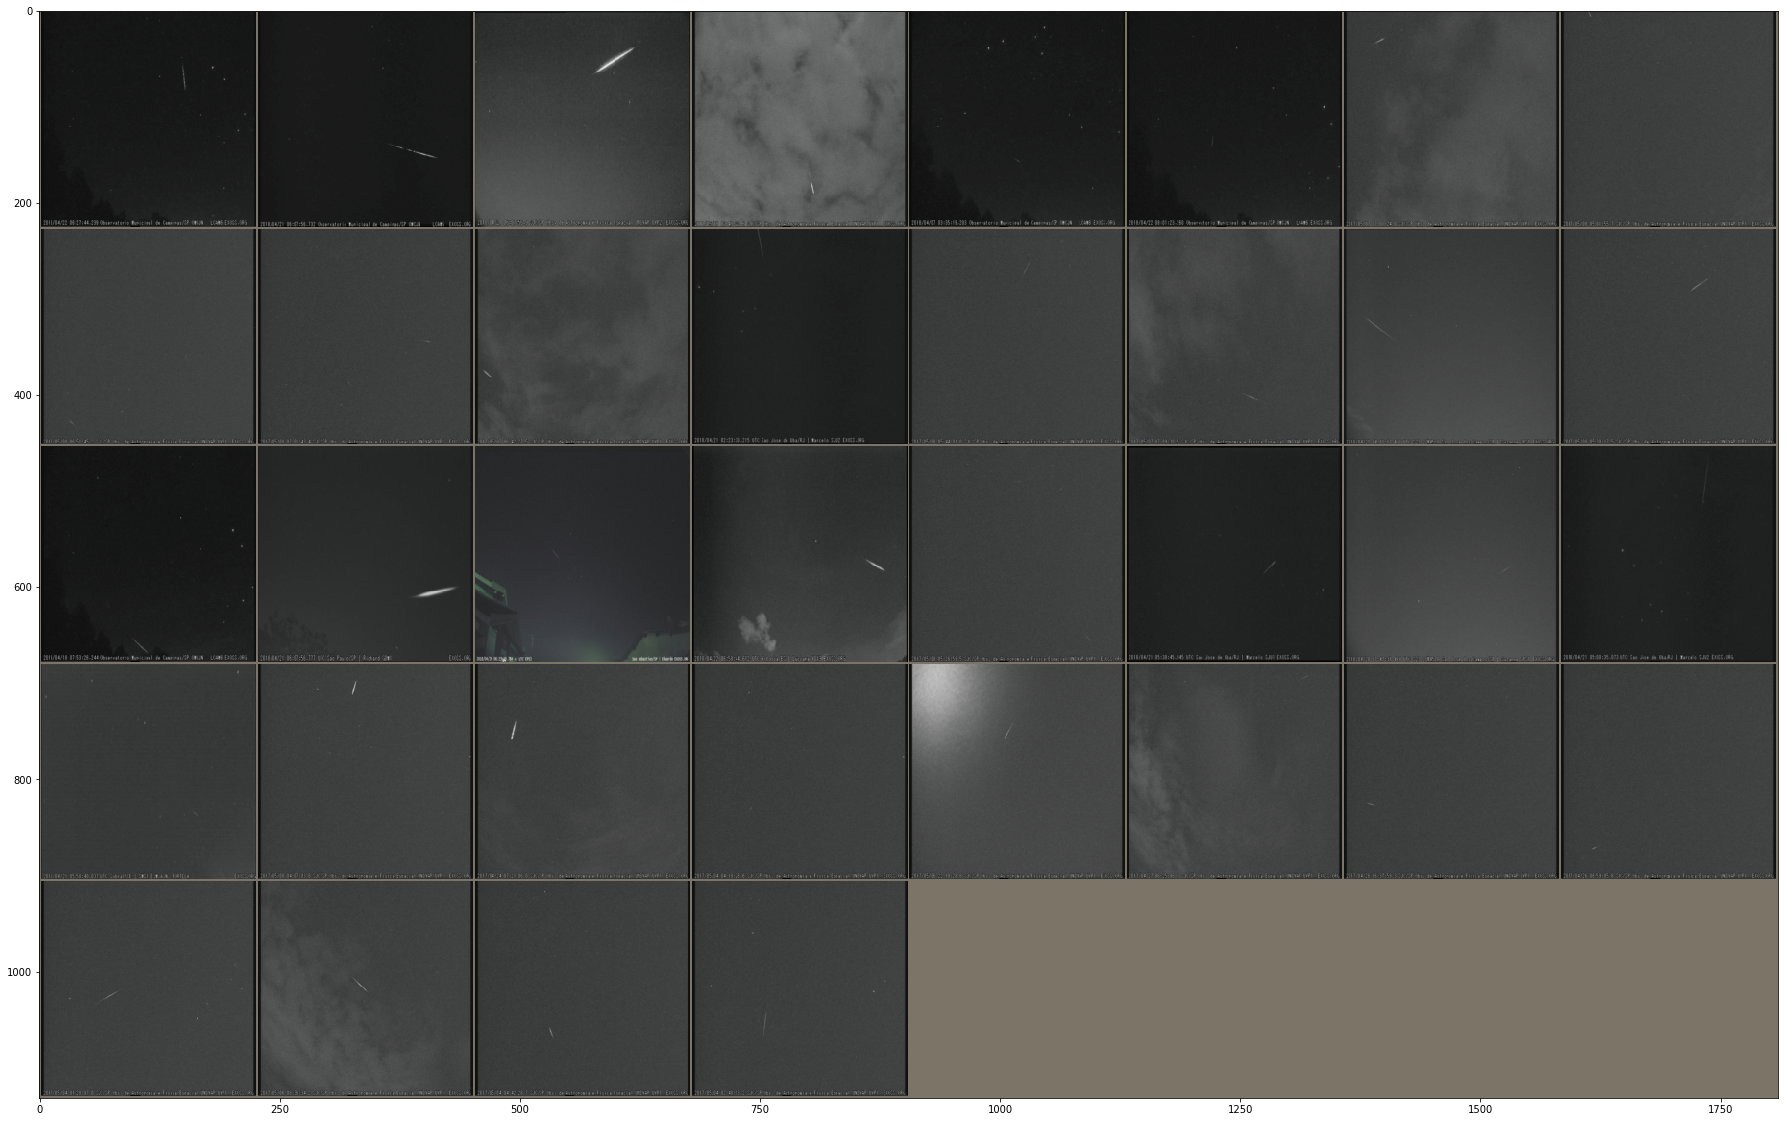

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
plt.figure(figsize=(40,20))
show_images(most_label(filtered_predictions,0,36),image_datasets['valid'])

In [ ]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 3, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
        
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))


def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Epoch 0 of 9
Training:
Total Loss=642.658220232
Accuracy=0.832942555686
Validation:
Total Loss=132.063108146
Accuracy=0.869249394673

Epoch 1 of 9
Training:
Total Loss=390.578344613
Accuracy=0.91266119578
Validation:
Total Loss=116.711497486
Accuracy=0.888619854722

Epoch 2 of 9
Training:
Total Loss=268.305373609
Accuracy=0.946658851114
Validation:
Total Loss=117.562703684
Accuracy=0.886198547215

Epoch 3 of 9
Training:
Total Loss=215.359629333
Accuracy=0.957209847597
Validation:
Total Loss=125.18103084
Accuracy=0.89588377724

Epoch 4 of 9
Training:
Total Loss=185.486585215
Accuracy=0.959554513482
Validation:
Total Loss=112.92680487
Accuracy=0.903147699758

Epoch 5 of 9
Training:
Total Loss=153.865823671
Accuracy=0.97245017585
Validation:
Total Loss=104.91299817
Accuracy=0.922518159806

Epoch 6 of 9
Training:
Total Loss=110.214606747
Accuracy=0.98182883939
Validation:
Total Loss=114.617038369
Accuracy=0.917675544794

Epoch 7 of 9
Training:
Total Loss=94.6300771236
Accuracy=0.9794841735

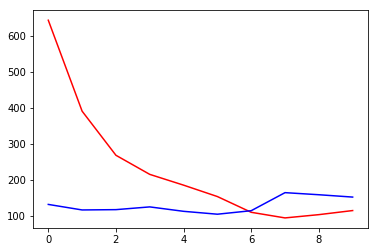